ENERGY ARBITRAGE VALUE ANALYSIS
This notebook is used to computed the energy arbitrage value captured with our optimal storage dispatch algorithm for each year (2015-2019) in Ontario electricity market. Round-trip efficiency used is = 100% and we assume perfect forecast of future electricity prices. The power capacity considered is = 1 MW and we study energy arbitrage for a range of battery capacity of 1 to 48 MWh. Results are plotted at the end.

In [1]:
##############################
## IMPORT AND PREPARE DATA ##
############################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
from pyomo.environ import *

# Import data
filename2 = 'HOEP_2015-2019_dataset.csv'
data = pd.read_csv(filename2)
data['Datetime'] = pd.to_datetime(data.Date) + pd.to_timedelta(data.Hour, unit='h')
cols_of_interest = ["Datetime", "Date", "Hour", "HOEP"]
data = data[cols_of_interest]

# Create different datasets for each year
df_2015 = data.loc[:8759]
df_2016 = data.loc[8760:17543]
df_2017 = data.loc[17544:26303]
df_2018 = data.loc[26304:35063]
df_2019 = data.loc[35064:]

# Definition of the hours of storage range values we will create
hours = np.arange(1,49,1)

In [3]:
##### 2019 ####
###############
df = df_2019.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)

start_time = datetime.now()
duration_YEAV = []
YEAV_hours_2019 = []

for duration in hours:
    
    Profits = []

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=1)

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
        
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): # max state of charge constraint. 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def value_constraint(model, t): # used to get the arbitrage value at each period. Positive or negative
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    #solver = SolverFactory('glpk')
    solver = SolverFactory('ipopt')
    solver.solve(model) 
        
    SOC = list(model.Z.get_values().values())
    last_period_end_SOC = SOC[-1]
        
    Profits.append(model.objective())
    
    duration_YEAV.append(sum(Profits)/1000)

YEAV_hours_2019.append(duration_YEAV)
EAV_2019 = pd.DataFrame(YEAV_hours_2019).T
EAV_2019.rename(columns={0: 'EAV'},inplace = True)
EAV_2019['Hours_storage'] = list(hours)
#EAV_2019.to_csv (r'C:\Users\Administrateur\Dropbox\Python\Battery algorithms\Thèse\Travail\Algorithm\RESULTS\value_storage\datasets\EAV_2019_8760.csv', 
#           index = False, header=True) # make sure you create csv file in same directory as notebook
print("running time:", datetime.now() - start_time)
EAV_2019

running time: 0:31:43.424696


,EAV,Hours_storage
0,16.960544,1
1,32.092671,2
2,41.213084,3
3,47.038333,4
4,51.398836,5
5,54.752190,6
6,57.441989,7
7,59.584250,8
8,61.265819,9
9,62.626166,10


In [4]:
##### 2018 ####
###############
df = df_2018.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)

start_time = datetime.now()
duration_YEAV = []
YEAV_hours = []

for duration in hours:
    
    Profits = []

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=1)

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
        
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def value_constraint(model, t):
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    #solver = SolverFactory('glpk')
    solver = SolverFactory('ipopt')
    solver.solve(model) 
        
    SOC = list(model.Z.get_values().values())
    last_period_end_SOC = SOC[-1]
        
    Profits.append(model.objective())
    
    duration_YEAV.append(sum(Profits)/1000)

YEAV_hours.append(duration_YEAV)
EAV_2018 = pd.DataFrame(YEAV_hours).T
EAV_2018.rename(columns={0: 'EAV'},inplace = True)
EAV_2018['Hours_storage'] = list(hours)
#EAV_2018.to_csv (r'C:\Users\Administrateur\Dropbox\Python\Battery algorithms\Thèse\Travail\Algorithm\RESULTS\value_storage\datasets\EAV_2018_8760.csv', 
#           index = False, header=True) # make sure you create csv file in same directory as notebook
print("running time:", datetime.now() - start_time)
EAV_2018

running time: 0:31:21.123136


,EAV,Hours_storage
0,22.740839,1
1,43.089071,2
2,55.923545,3
3,64.841843,4
4,71.567035,5
5,76.754283,6
6,80.734030,7
7,83.825018,8
8,86.240231,9
9,88.195403,10


In [5]:
##### 2017 ####
###############
df = df_2017.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)

start_time = datetime.now()
duration_YEAV = []
YEAV_hours = []

for duration in hours:
    
    Profits = []

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=1)

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
        
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def value_constraint(model, t):
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    #solver = SolverFactory('glpk')
    solver = SolverFactory('ipopt')
    solver.solve(model) 
        
    SOC = list(model.Z.get_values().values())
    last_period_end_SOC = SOC[-1]
        
    Profits.append(model.objective())
    
    duration_YEAV.append(sum(Profits)/1000)

YEAV_hours.append(duration_YEAV)
EAV_2017 = pd.DataFrame(YEAV_hours).T
EAV_2017.rename(columns={0: 'EAV'},inplace = True)
EAV_2017['Hours_storage'] = list(hours)
#EAV_2017.to_csv (r'C:\Users\Administrateur\Dropbox\Python\Battery algorithms\Thèse\Travail\Algorithm\RESULTS\value_storage\datasets\EAV_2017_8760.csv', 
#           index = False, header=True) # make sure you create csv file in same directory as notebook
print("running time:", datetime.now() - start_time)
EAV_2017

running time: 0:26:55.653175


,EAV,Hours_storage
0,22.277383,1
1,42.700842,2
2,53.922450,3
3,61.453268,4
4,66.931904,5
5,71.262188,6
6,74.593826,7
7,77.190545,8
8,79.282497,9
9,81.010547,10


In [6]:
##### 2016 ####
###############
df = df_2016.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)

start_time = datetime.now()
duration_YEAV = []
YEAV_hours = []

for duration in hours:
    
    Profits = []

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=1)

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
        
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def value_constraint(model, t):
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    #solver = SolverFactory('glpk')
    solver = SolverFactory('ipopt')
    solver.solve(model) 
        
    SOC = list(model.Z.get_values().values())
    last_period_end_SOC = SOC[-1]
        
    Profits.append(model.objective())
    
    duration_YEAV.append(sum(Profits)/1000)

YEAV_hours.append(duration_YEAV)
EAV_2016 = pd.DataFrame(YEAV_hours).T
EAV_2016.rename(columns={0: 'EAV'},inplace = True)
EAV_2016['Hours_storage'] = list(hours)
#EAV_2016.to_csv (r'C:\Users\Administrateur\Dropbox\Python\Battery algorithms\Thèse\Travail\Algorithm\RESULTS\value_storage\datasets\EAV_2016_8760.csv', 
#           index = False, header=True) # make sure you create csv file in same directory as notebook
print("running time:", datetime.now() - start_time)
EAV_2016

running time: 0:25:54.086038


,EAV,Hours_storage
0,18.165253,1
1,34.932492,2
2,45.165979,3
3,51.873259,4
4,56.996369,5
5,60.960614,6
6,63.990015,7
7,66.364363,8
8,68.233852,9
9,69.750595,10


In [7]:
##### 2015 ####
###############
df = df_2015.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)

start_time = datetime.now()
duration_YEAV = []
YEAV_hours = []

for duration in hours:
    
    Profits = []

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=1)

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
        
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def value_constraint(model, t):
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    #solver = SolverFactory('glpk')
    solver = SolverFactory('ipopt')
    solver.solve(model) 
        
    SOC = list(model.Z.get_values().values())
    last_period_end_SOC = SOC[-1]
        
    Profits.append(model.objective())
    
    duration_YEAV.append(sum(Profits)/1000)

YEAV_hours.append(duration_YEAV)
EAV_2015 = pd.DataFrame(YEAV_hours).T
EAV_2015.rename(columns={0: 'EAV'},inplace = True)
EAV_2015['Hours_storage'] = list(hours)
#EAV_2015.to_csv (r'C:\Users\Administrateur\Dropbox\Python\Battery algorithms\Thèse\Travail\Algorithm\RESULTS\value_storage\datasets\EAV_2015_8760.csv', 
#           index = False, header=True) # make sure you create csv file in same directory as notebook
print("running time:", datetime.now() - start_time)
EAV_2015

running time: 0:25:40.083179


,EAV,Hours_storage
0,22.896003,1
1,43.883064,2
2,56.380658,3
3,63.640461,4
4,68.778849,5
5,72.673448,6
6,75.638959,7
7,77.844226,8
8,79.533412,9
9,80.834439,10


In [2]:
########################################################
### EXTRACT YEARLY RESULTS AND BUILD MARGINAL VALUE ###
######################################################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List

#EAV_2015 = pd.read_csv('EAV_2015_8760.csv')
EAV_2015['Year'] = 2015
EAV_2015['MEAV'] = (EAV_2015['EAV'] - EAV_2015['EAV'].shift(1,fill_value=0))

#EAV_2016 = pd.read_csv('EAV_2016_8760.csv')
EAV_2016['Year'] = 2016
EAV_2016['MEAV'] = (EAV_2016['EAV'] - EAV_2016['EAV'].shift(1,fill_value=0))

#EAV_2017 = pd.read_csv('EAV_2017_8760.csv')
EAV_2017['Year'] = 2017
EAV_2017['MEAV'] = (EAV_2017['EAV'] - EAV_2017['EAV'].shift(1,fill_value=0))

#EAV_2018 = pd.read_csv('EAV_2018_8760.csv')
EAV_2018['Year'] = 2018
EAV_2018['MEAV'] = (EAV_2018['EAV'] - EAV_2018['EAV'].shift(1,fill_value=0))

#EAV_2019 = pd.read_csv('EAV_2019_8760.csv')
EAV_2019['Year'] = 2019
EAV_2019['MEAV'] = (EAV_2019['EAV'] - EAV_2019['EAV'].shift(1,fill_value=0))

df = pd.concat([EAV_2015, EAV_2016, EAV_2017, EAV_2018, EAV_2019], ignore_index=True)

df = df.rename(columns={'Year': 'Année','EAV':"Valeur d'arbitrage d'énergie", 
            'MEAV':"Valeur marginale d'arbitrage d'énergie",'Hours_storage':"Heures de stockages"})
df = df[['Année',"Heures de stockages","Valeur d'arbitrage d'énergie",
         "Valeur marginale d'arbitrage d'énergie"]]
df

,Année,Heures de stockages,Valeur d'arbitrage d'énergie,Valeur marginale d'arbitrage d'énergie
0,2015,1,22.896003,22.896003
1,2015,2,43.883064,20.987061
2,2015,3,56.380658,12.497594
3,2015,4,63.640461,7.259804
4,2015,5,68.778849,5.138387
...,...,...,...,...
235,2019,44,76.483711,0.158592
236,2019,45,76.638625,0.154914
237,2019,46,76.790640,0.152014
238,2019,47,76.939946,0.149306


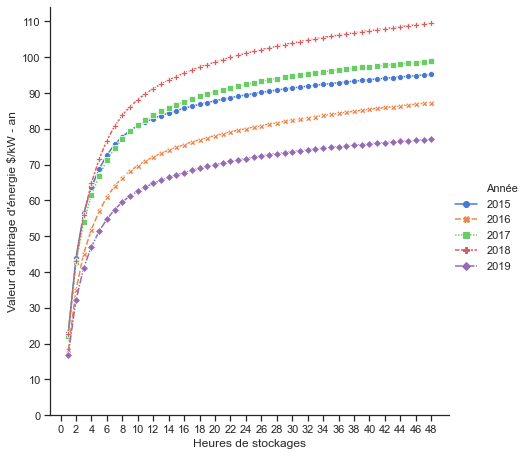

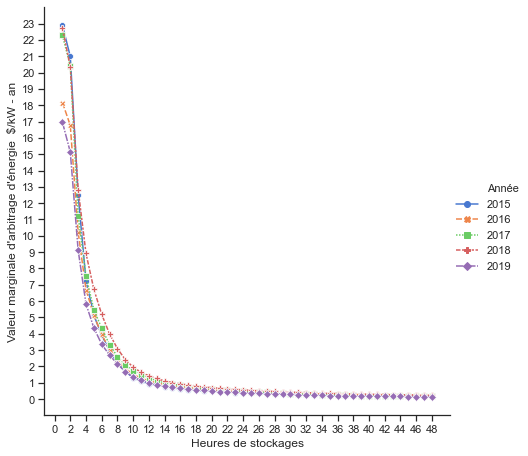

In [4]:
######################
### VIZUALISATION ###
#####################
%matplotlib inline  
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt 
from IPython.display import Image
sns.set()

# Plot Value of storage
with sns.axes_style("ticks", {"grid.color": "white"}):
    sns.set_palette("bright")
    g = sns.relplot(x="Heures de stockages", y="Valeur d'arbitrage d'énergie", hue='Année',style='Année',
                    markers=True, kind='line',palette="muted", legend="full",height=6.5, data=df)
    plt.ylabel("Valeur d'arbitrage d'énergie $/kW - an")
    plt.xlabel("Heures de stockages")
    plt.yticks(list(range(0,120,10)))
    plt.xticks(list(range(0,50,2)))
    #plt.savefig('VEA_2015-2019.png',dpi=1100, bbox_inches='tight')
    
# Value of storage plot
with sns.axes_style("ticks", {"grid.color": "white"}):
    g = sns.relplot(x="Heures de stockages", y="Valeur marginale d'arbitrage d'énergie", hue='Année',
                    style='Année',markers=True, kind='line',palette="muted",height=6.5, clip_on=False, 
                    legend="full", data=df)
    plt.ylabel("Valeur marginale d'arbitrage d'énergie  $/kW - an")
    plt.xlabel("Heures de stockages")
    plt.yticks(list(range(0,24,1)))
    plt.xticks(list(range(0,50,2)))
    #plt.savefig('VMEA_2015-2019.png',dpi=1100, bbox_inches='tight')